In [1]:
import scanpy as sc
import os
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


# Read Data

## Get data
Read data from the raw ```txt.gz``` files is slow, so we save it as a pickle file.

In [3]:
def get_data(data_path = "../data/GSE70580_RAW/"):
    file_names = os.listdir(data_path)
    cell_names = [file_name.split(".")[0] for file_name in file_names]
    file_paths = [data_path + file_name for file_name in file_names]
    dfs = [pd.read_table(file_path, index_col=[0, 1]) for file_path in file_paths]
    
    # RPKM
    rpkms = [df.RPKM.rename(name) for name, df in zip(cell_names, dfs)]
    rpkm_df = pd.concat(rpkms, axis=1)
    
    # Reads
    reads = [df.Reads.rename(name) for name, df in zip(cell_names, dfs)]
    read_df = pd.concat(reads, axis=1)
    
    return rpkm_df, read_df

# rpkm_df, read_df = get_data()

# with open("../data/GSE70580.pkl", "rb") as file:
#     pkl.dump(obj=[rpkm_df, read_df], file=file)

In [4]:
with open("../data/GSE70580.pkl", "rb") as file:
    rpkm_df, read_df = pkl.load(file)

## Get cell-type labels

In [5]:
cell_type = [cell_name.split('_')[4] for cell_name in read_df.columns.tolist()]
obs = pd.DataFrame(data=cell_type, index=read_df.columns.tolist(), columns=["type"])
obs

type
GSM1810510_T74_P1_A9_ILC1_expression   ILC1
GSM1810511_T74_P1_B4_NK_expression       NK
GSM1810512_T74_P1_B7_ILC2_expression   ILC2
GSM1810513_T74_P1_B9_NK_expression       NK
GSM1810514_T74_P1_D10_ILC2_expression  ILC2
...                                     ...
GSM1811159_T86_P4_H2_ILC3_expression   ILC3
GSM1811160_T86_P4_H3_ILC3_expression   ILC3
GSM1811161_T86_P4_H4_ILC3_expression   ILC3
GSM1811162_T86_P4_H5_ILC3_expression   ILC3
GSM1811163_T86_P4_H8_ILC3_expression   ILC3

[648 rows x 1 columns]

## Rearrange Gene names

In [6]:
var = rpkm_df.index.to_frame()

In [7]:
var.columns = ['symbol', "id"]
var

symbol  \
#Gene symbol                         Refseq/Ensembl ID                                         
CTD-2588J6.1                         ENST00000566728                            CTD-2588J6.1   
RP11-433M22.1                        ENST00000579033                           RP11-433M22.1   
CTD-2588J6.2                         ENST00000563841                            CTD-2588J6.2   
RP13-100A9.2                         ENST00000428431                            RP13-100A9.2   
MTVR2                                NR_027025                                         MTVR2   
...                                                                                      ...   
ERCC_0.22888184:mix1_0.45776367:mix2 ERCC-00041         ERCC_0.22888184:mix1_0.45776367:mix2   
                                     ERCC-00081         ERCC_0.22888184:mix1_0.45776367:mix2   
ERCC_0.11444092:mix1_0.22888184:mix2 ERCC-00086         ERCC_0.11444092:mix1_0.22888184:mix2   
ERCC_0.05722046:mix1_0.11444092:mix2 ERCC-00061         ERCC_0.05722046:mix1_0.11444092:mix2   
ERCC_0.01430512:mix1_0.02861023:mix2 ERCC-00048         ERCC_0.01430512:mix1_0.02861023:mix2   

                                                                     id  
#Gene symbol                         Refseq/Ensembl ID                   
CTD-2588J6.1                         ENST00000566728    ENST00000566728  
RP11-433M22.1                        ENST00000579033    ENST00000579033  
CTD-2588J6.2                         ENST00000563841    ENST00000563841  
RP13-100A9.2                         ENST00000428431    ENST00000428431  
MTVR2                                NR_027025                NR_027025  
...                                                                 ...  
ERCC_0.22888184:mix1_0.45776367:mix2 ERCC-00041              ERCC-00041  
                                     ERCC-00081              ERCC-00081  
ERCC_0.11444092:mix1_0.22888184:mix2 ERCC-00086              ERCC-00086  
ERCC_0.05722046:mix1_0.11444092:mix2 ERCC-00061              ERCC-00061  
ERCC_0.01430512:mix1_0.02861023:mix2 ERCC-00048              ERCC-00048  

[64535 rows x 2 columns]

In [8]:
var.index = var['symbol']
rpkm_df.index = var['symbol']
read_df.index = var['symbol']

## Write data into scanpy anndata

In [9]:
adata = sc.AnnData(X=read_df.T, obs=obs, var=var)
#adata = sc.AnnData(X=rpkm_df.T, obs=obs, var=var)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
adata.var_names_make_unique()

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/anndata/utils.py:87: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-4', 'LINC00202-1', 'LINC00202-2']
  warnings.warn(


In [11]:
adata

AnnData object with n_obs × n_vars = 648 × 64535
    obs: 'type'
    var: 'symbol', 'id'

## Get rid of ERCC

In [12]:
adata = adata[:, adata.var['id'].apply(lambda x: x[0:4] != "ERCC")]
adata

View of AnnData object with n_obs × n_vars = 648 × 64443
    obs: 'type'
    var: 'symbol', 'id'

# Preprocessing

## Show highly expressed genes

/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


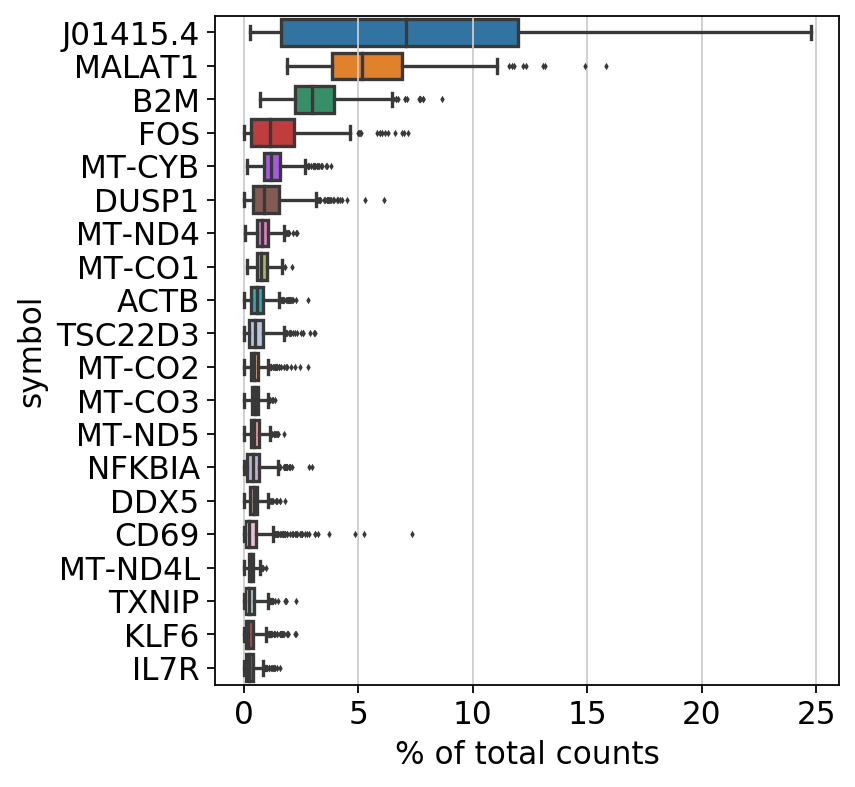

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols="symbol")

## Filter cells and genes

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 38428 genes that are detected in less than 3 cells


In [15]:
adata.var['mt'] = adata.var['symbol'].str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'type' as categorical
... storing 'symbol' as categorical
... storing 'id' as categorical


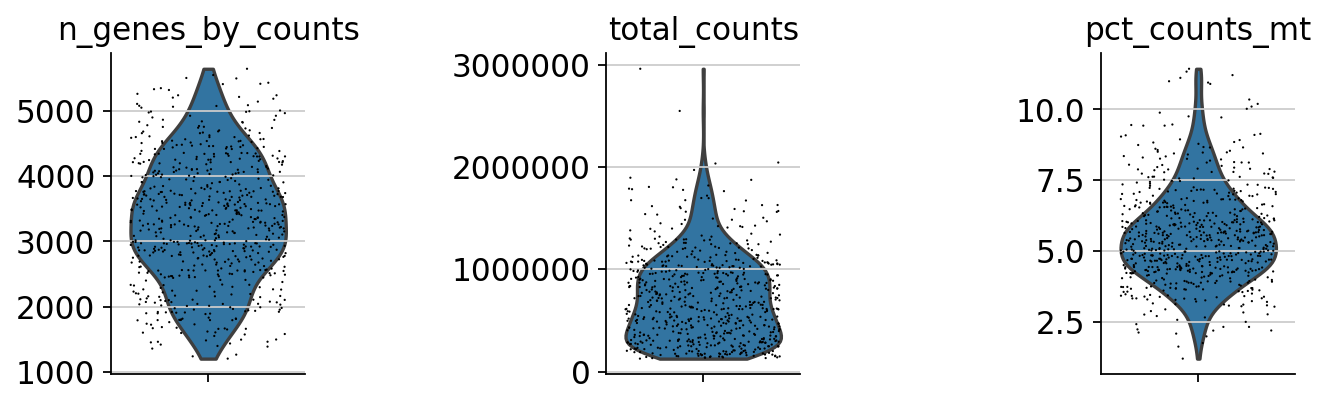

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

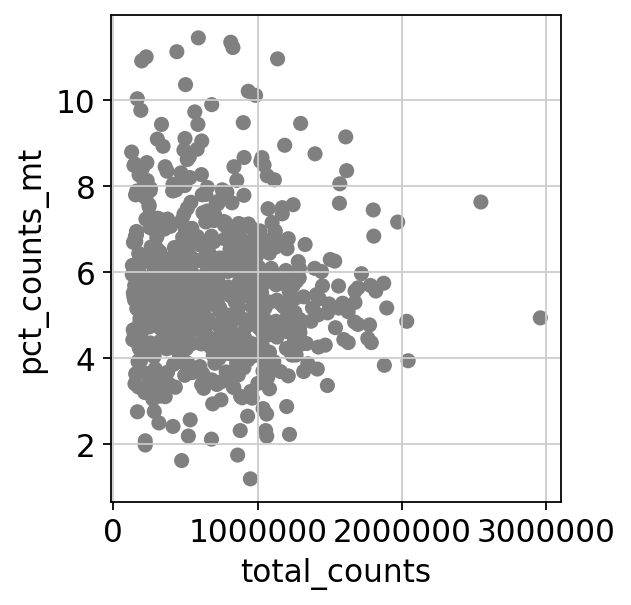

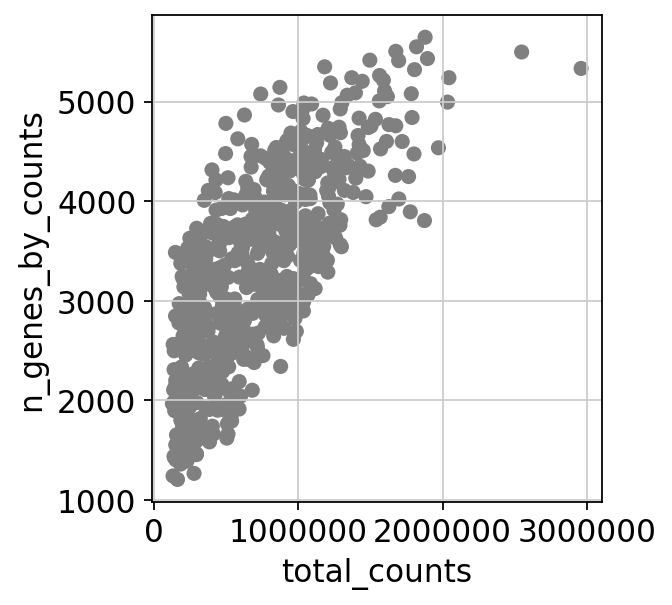

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
adata = adata[adata.obs.total_counts < 2000000, :]
adata

View of AnnData object with n_obs × n_vars = 644 × 26015
    obs: 'type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalize, log transform, and scaling

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.pp.log1p(adata)

In [22]:
#sc.pp.scale(adata, max_value=10)

## Identify and keep highly variable genes

In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


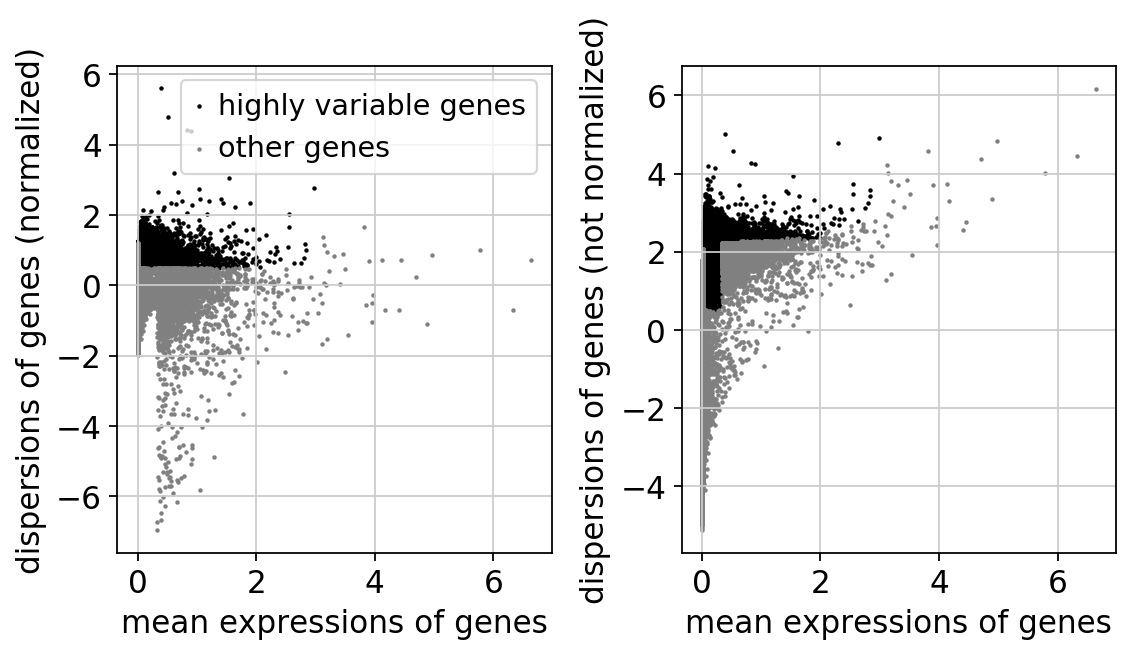

In [24]:
sc.pl.highly_variable_genes(adata)

In [25]:
adata.raw = adata

In [26]:
adata = adata[:, adata.var.highly_variable]

In [27]:
adata

View of AnnData object with n_obs × n_vars = 644 × 8724
    obs: 'type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'symbol', 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

# Dimensional Reduction and Visualization

## PCA

In [28]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


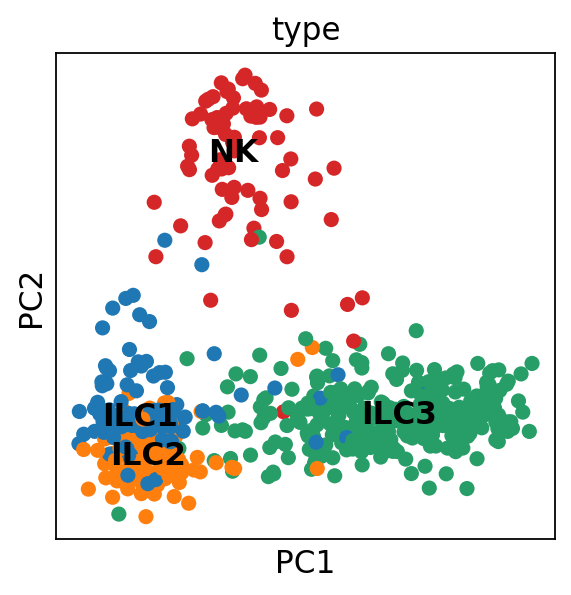

In [29]:
sc.pl.pca(adata, color='type', legend_loc='on data')

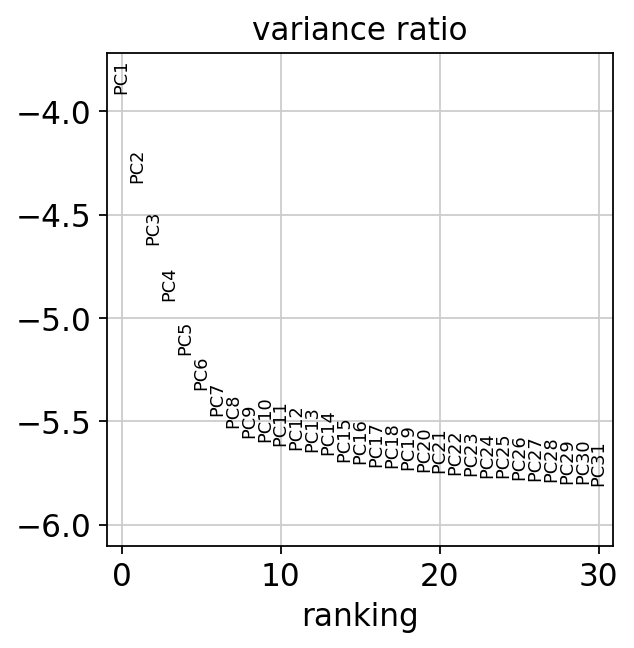

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


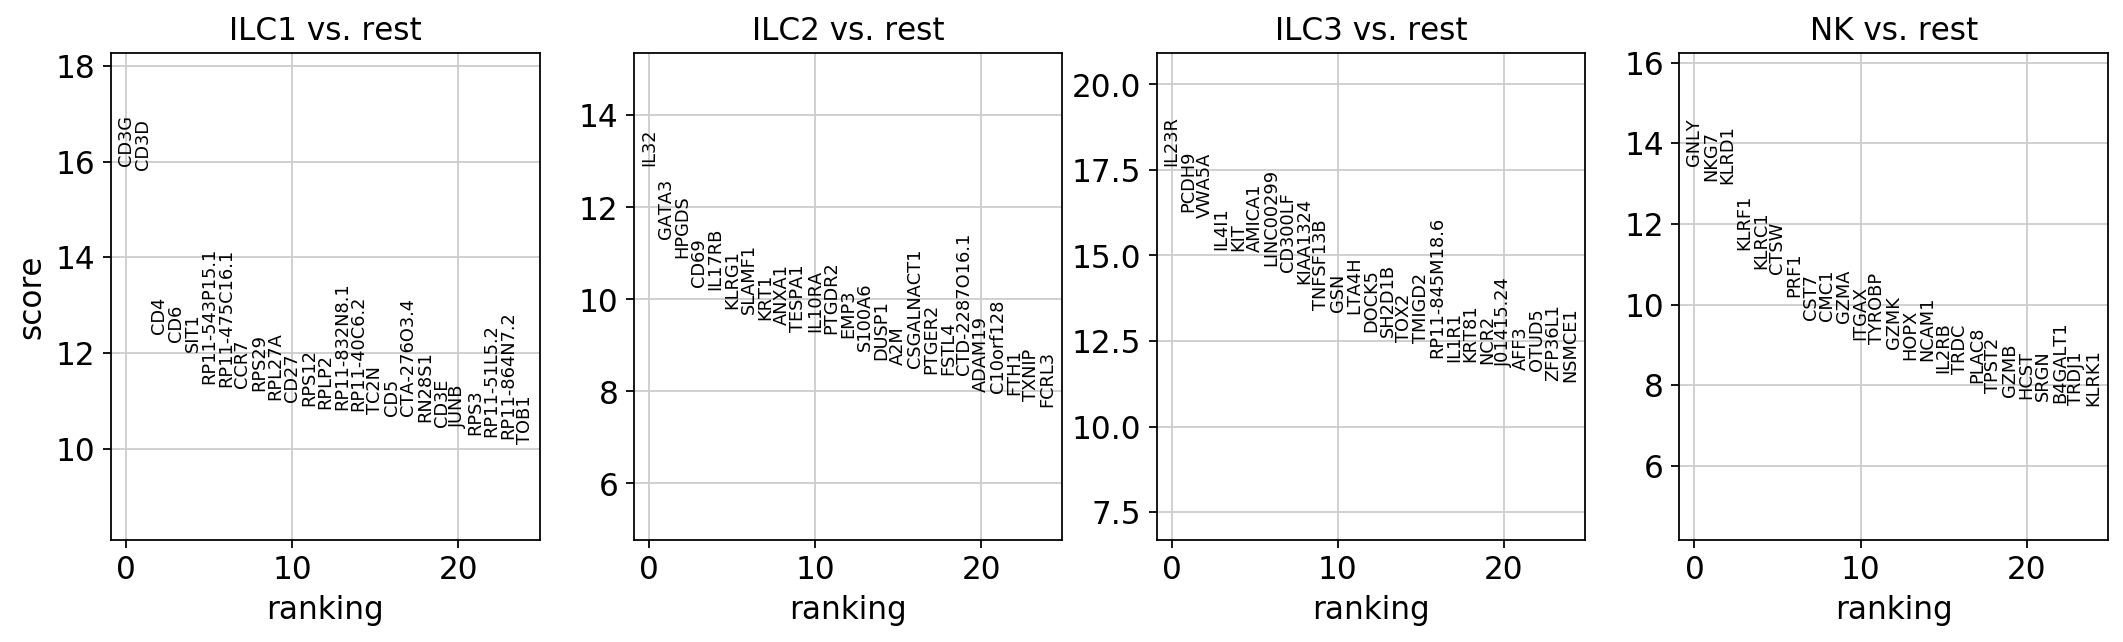

In [31]:
sc.tl.rank_genes_groups(adata, 'type', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="symbol")

## UMAP

In [32]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [33]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


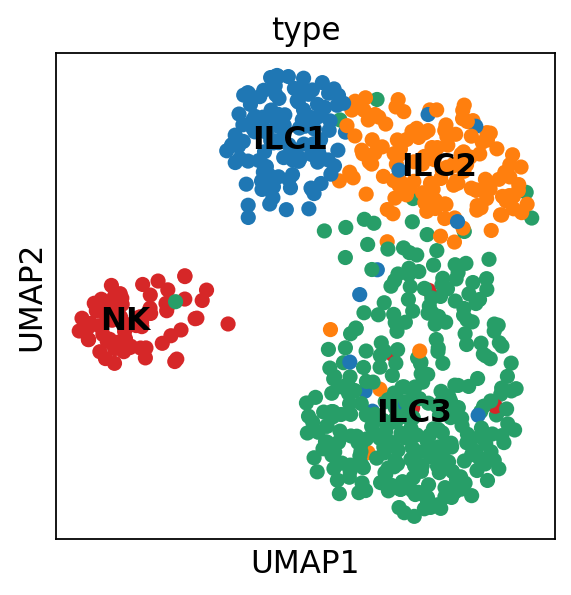

In [81]:
sc.pl.umap(adata, color='type', legend_loc='on data')

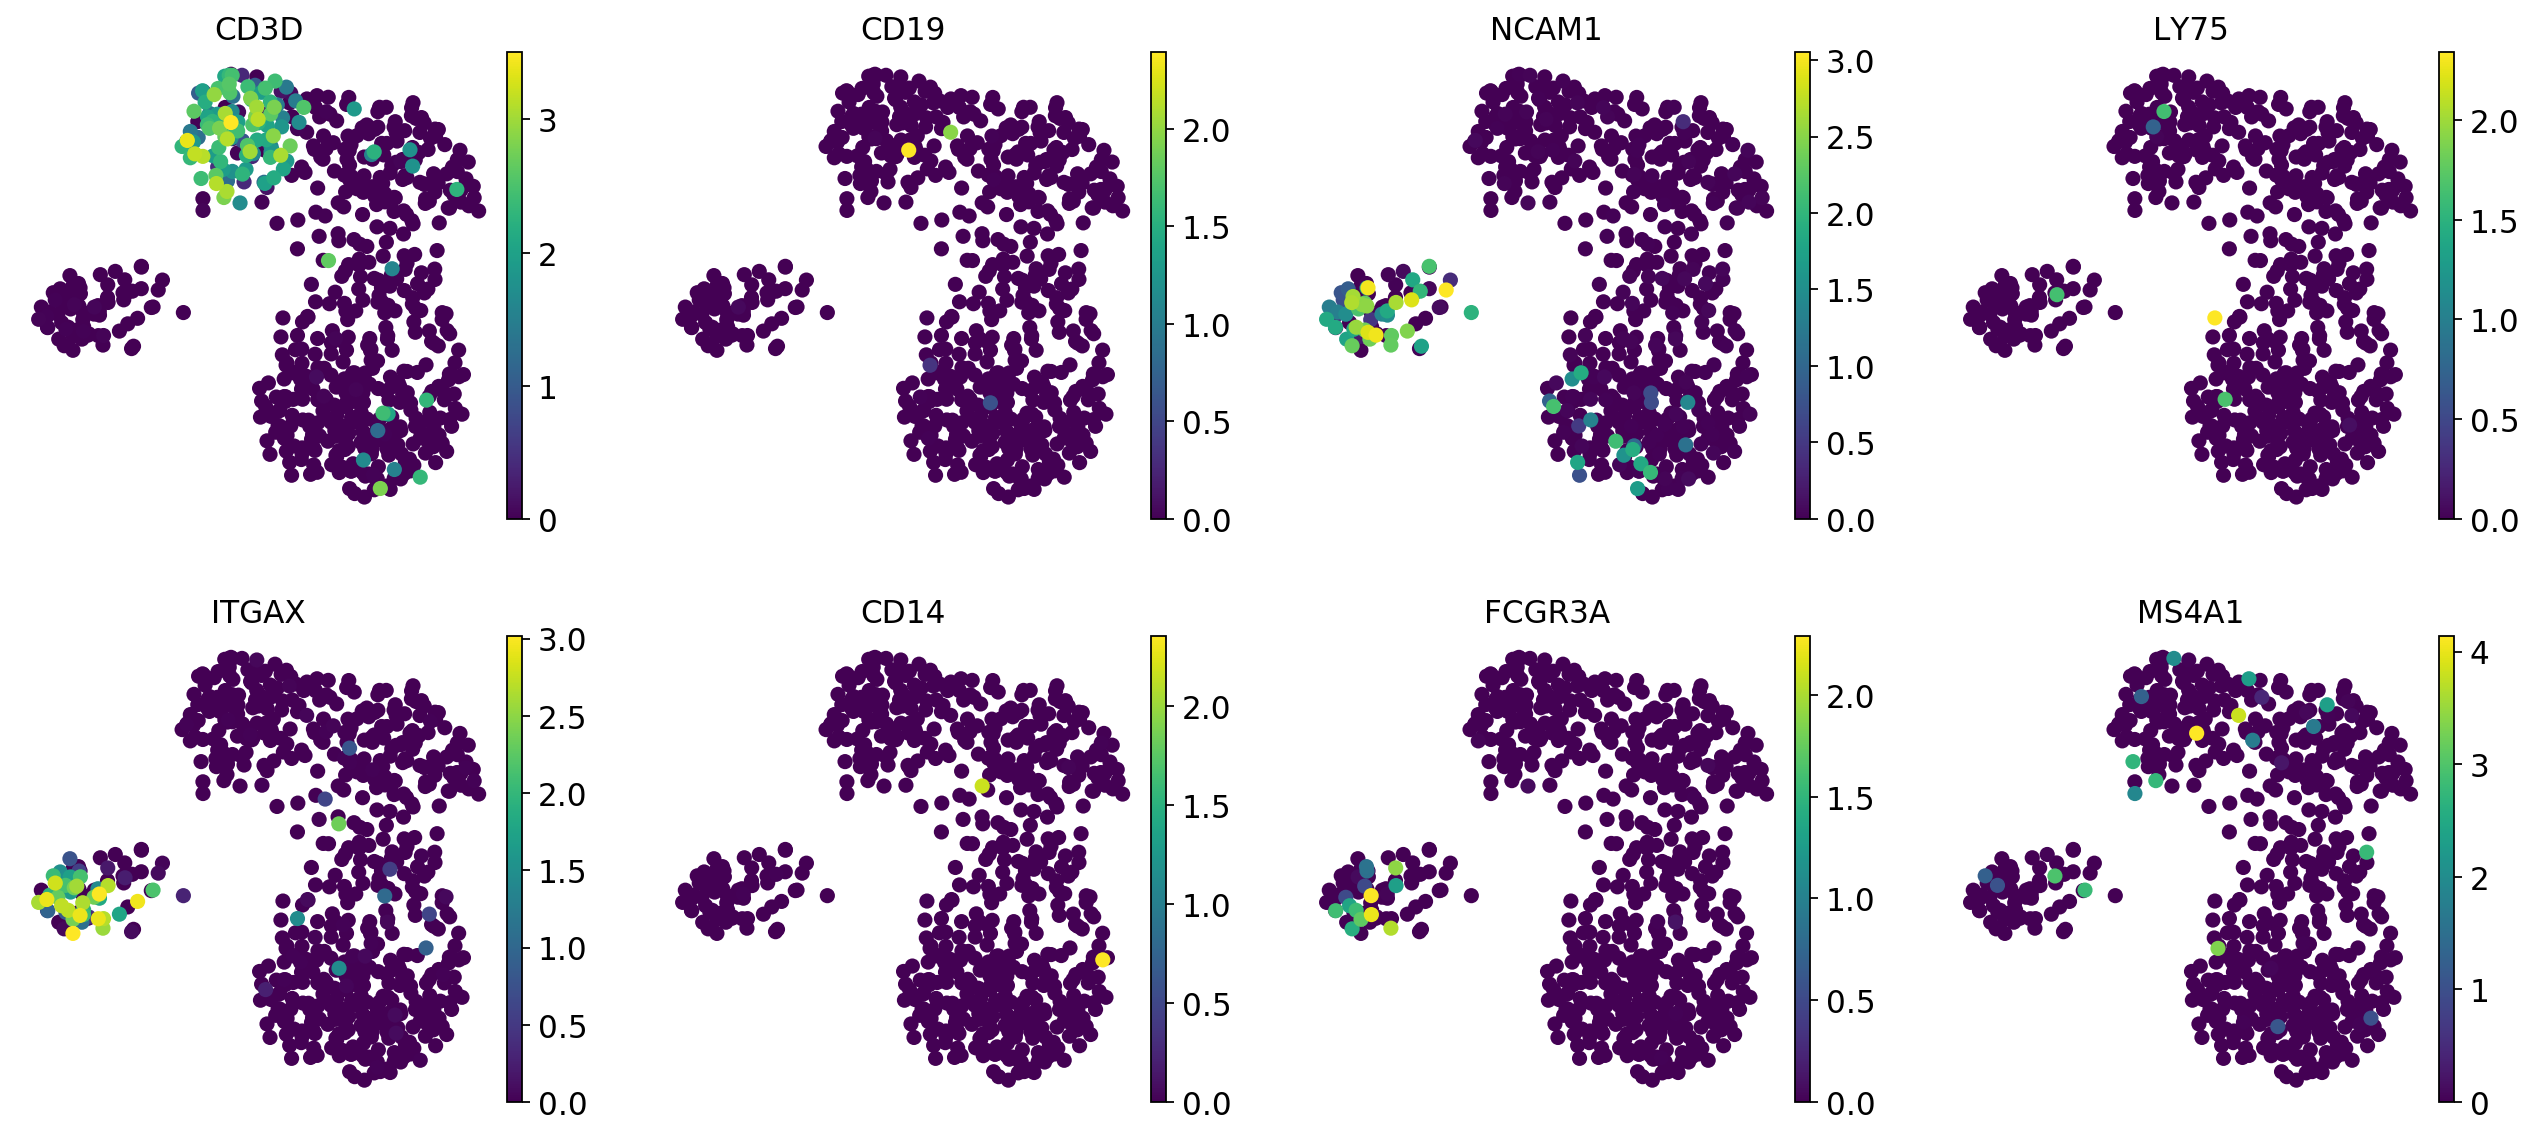

In [34]:
lineage_markers = ['CD3D', 'CD19', 'NCAM1', 'LY75', "ITGAX", "CD14", "FCGR3A", "MS4A1"]
sc.pl.umap(adata.raw.to_adata(), color=lineage_markers, legend_loc='on data', frameon=False, ncols=4)

In [35]:
ilc1_markers = ['KLRB1', 'NFIL3', 'RUNX3', 'TNF']
ilc2_markers = ['AREG', 'BCL11B', 'ETS1', 'GATA3', 'GFI1', 'IL13', 'IL1RL1', 'IL5', 'PTGDR2']
ilc3_markers = ['AHR', 'CCL3', 'IL17A', 'IL22', 'IL23R', 'KIT', 'LTB4R', 'LTB4R2', 'LTC4S', 'NCR2', 'RORC']
nk_markers = ['EOMES', 'KLRD1', 'NCAM1', 'NCR1']

In [36]:
ilc1_markers = ['KLRB1', 'NFIL3', 'RUNX3']
ilc2_markers = ['AREG', 'BCL11B', 'ETS1', 'GATA3', 'GFI1', 'IL13', 'IL1RL1', 'PTGDR2']
ilc3_markers = ['AHR', 'CCL3', 'IL22', 'IL23R', 'KIT', 'LTB4R', 'LTB4R2', 'NCR2', 'RORC']
nk_markers = ['EOMES', 'KLRD1', 'NCAM1', 'NCR1']

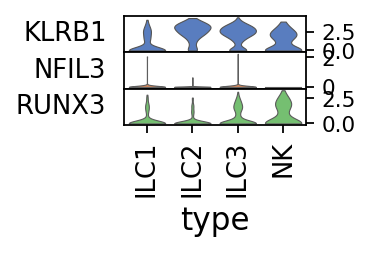

In [37]:
sc.pl.stacked_violin(adata, ilc1_markers, groupby='type', rotation=90, swap_axes=True);

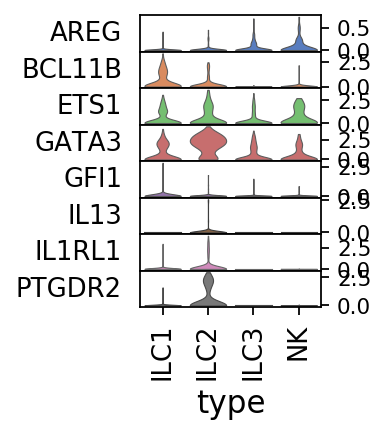

In [38]:
sc.pl.stacked_violin(adata, ilc2_markers, groupby='type', rotation=90, swap_axes=True);

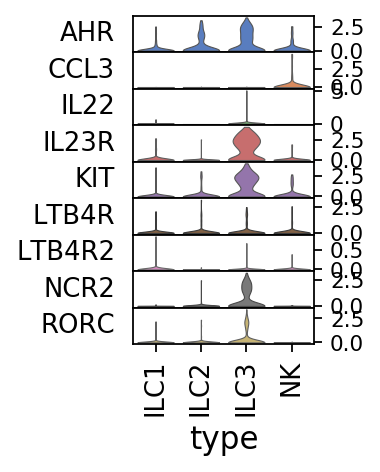

In [39]:
sc.pl.stacked_violin(adata, ilc3_markers, groupby='type', rotation=90, swap_axes=True);

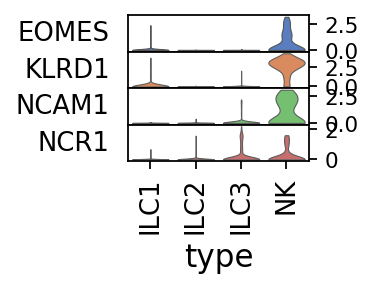

In [40]:
sc.pl.stacked_violin(adata, nk_markers, groupby='type', rotation=90, swap_axes=True);

# Classification Tests

## Gaussian naïve Bayes

In [41]:
import sklearn as skl
import sklearn.naive_bayes
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

In [42]:
classifier = skl.naive_bayes.GaussianNB()
classifier.fit(adata.raw.to_adata().X, adata.obs.type)
confusion_matrix(y_true=adata.obs.type, y_pred=classifier.predict(adata.raw.to_adata().X))

array([[126,   0,   0,   0],
       [  0, 136,   0,   0],
       [  0,   0, 308,   0],
       [  0,   0,   0,  74]])

In [43]:
classifier = skl.naive_bayes.GaussianNB()
y_pred = cross_val_predict(classifier, adata.raw.to_adata().X, adata.obs.type, cv=20)
confusion_matrix(y_true=adata.obs.type, y_pred=y_pred)

array([[ 94,   3,  28,   1],
       [  8,  80,  48,   0],
       [  3,   2, 303,   0],
       [  3,   4,  65,   2]])

In [44]:
classifier = skl.naive_bayes.GaussianNB()
y_pred = cross_val_predict(classifier, adata.raw.to_adata().X, adata.obs.type, cv=10)
confusion_matrix(y_true=adata.obs.type, y_pred=y_pred)

array([[ 91,   2,  32,   1],
       [  9,  70,  57,   0],
       [  1,   4, 303,   0],
       [  3,   5,  64,   2]])

In [45]:
classifier = skl.naive_bayes.GaussianNB()
y_pred = cross_val_predict(classifier, adata.raw.to_adata().X, adata.obs.type, cv=50)
confusion_matrix(y_true=adata.obs.type, y_pred=y_pred)

array([[ 97,   2,  26,   1],
       [  8,  81,  47,   0],
       [  1,   1, 306,   0],
       [  4,   3,  65,   2]])

In [46]:
adata.obs['GaussianNB'] = y_pred

... storing 'GaussianNB' as categorical


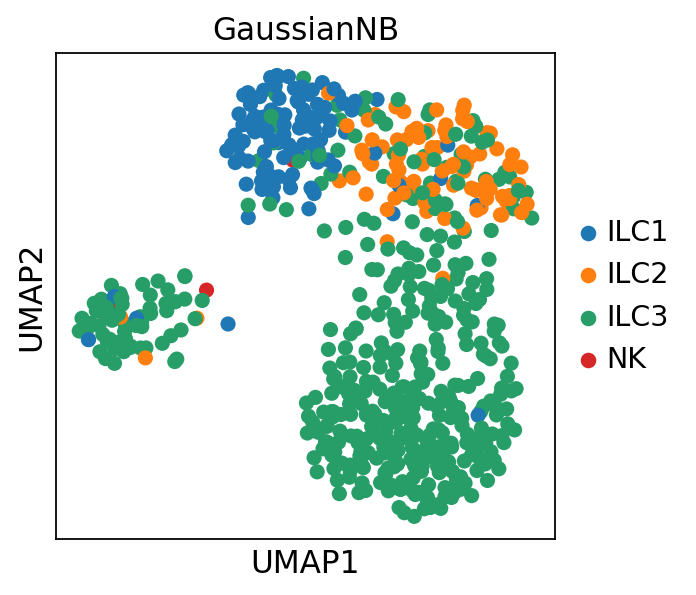

In [47]:
sc.pl.umap(adata, color='GaussianNB')

## Decision trees

### Depth 2

ILC1  ILC2  ILC3  NK
ILC1   103     8    15   0
ILC2     5   126     5   0
ILC3     2    40   266   0
NK       5    47     3  19

[Text(624.0, 506.6666666666667, 'IL23R <= 0.012\ngini = 0.675\nsamples = 644\nvalue = [126, 136, 308, 74]\nclass = ILC3'),
 Text(312.0, 304.0, 'CD3G <= 0.004\ngini = 0.699\nsamples = 336\nvalue = [111, 131, 42, 52]\nclass = ILC2'),
 Text(156.0, 101.33333333333337, 'gini = 0.596\nsamples = 221\nvalue = [8, 126, 40, 47]\nclass = ILC2'),
 Text(468.0, 101.33333333333337, 'gini = 0.194\nsamples = 115\nvalue = [103, 5, 2, 5]\nclass = ILC1'),
 Text(936.0, 304.0, 'KLRD1 <= 2.082\ngini = 0.246\nsamples = 308\nvalue = [15, 5, 266, 22]\nclass = ILC3'),
 Text(780.0, 101.33333333333337, 'gini = 0.15\nsamples = 289\nvalue = [15, 5, 266, 3]\nclass = ILC3'),
 Text(1092.0, 101.33333333333337, 'gini = 0.0\nsamples = 19\nvalue = [0, 0, 0, 19]\nclass = NK')]

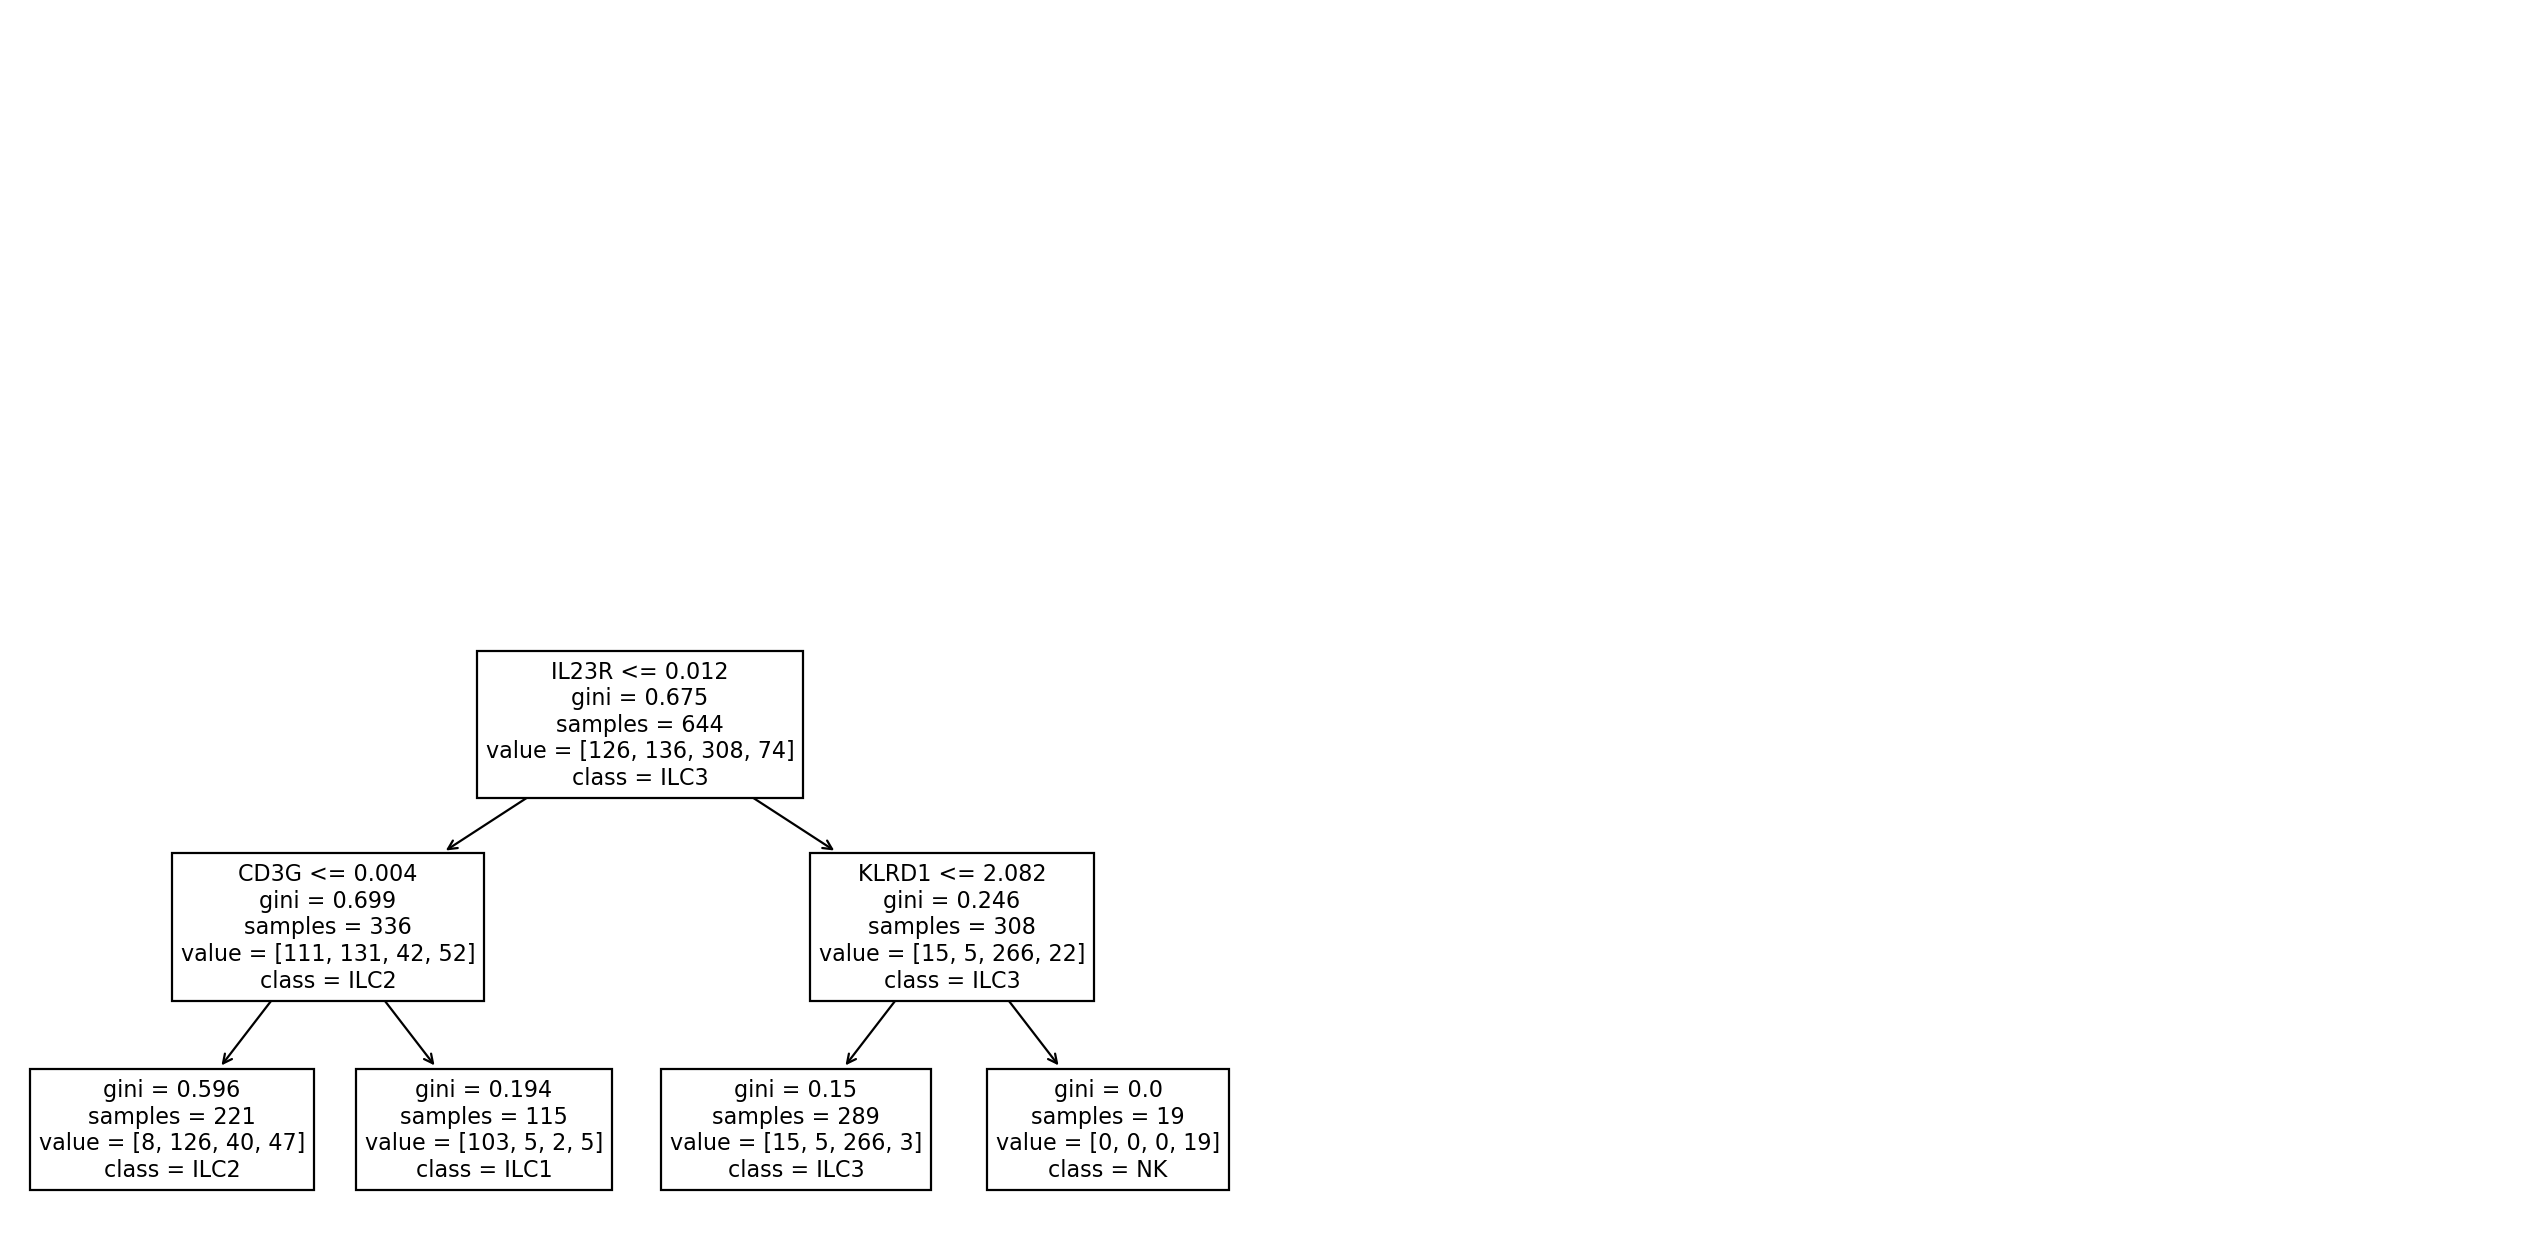

In [72]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=2)
classifier.fit(adata.raw.to_adata().X, adata.obs.type)
display(pd.DataFrame(confusion_matrix(y_true=adata.obs.type, 
                                      y_pred=classifier.predict(adata.raw.to_adata().X)
                                     ),
                     index=classifier.classes_, columns=classifier.classes_)
       )
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(classifier, ax=ax, fontsize=10,
               feature_names=adata.raw.to_adata().var.symbol, class_names=classifier.classes_) 

... storing 'Tree2' as categorical


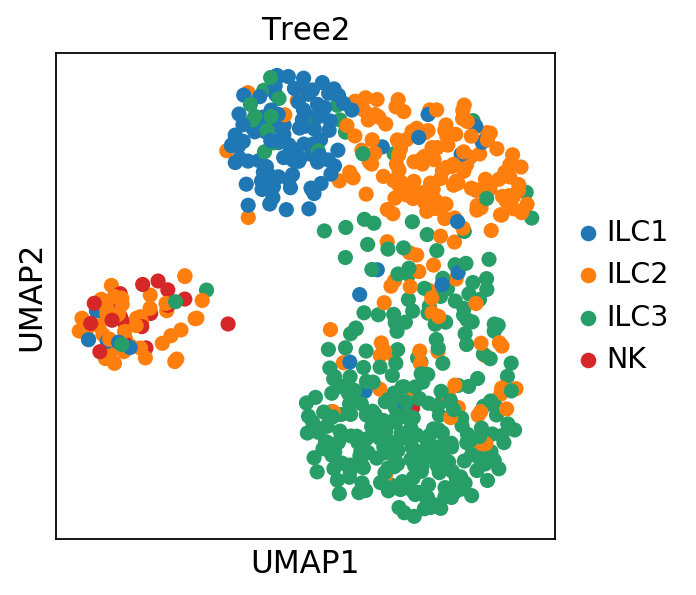

In [73]:
adata.obs['Tree2'] = classifier.predict(adata.raw.to_adata().X)
sc.pl.umap(adata, color='Tree2')

### Depth 3

ILC1  ILC2  ILC3  NK
ILC1   115    10     1   0
ILC2     4   128     4   0
ILC3     2    39   267   0
NK       0     2     5  67

[Text(1497.6, 638.4, 'GNLY <= 3.724\ngini = 0.75\nsamples = 644\nvalue = [161.0, 161.0, 161.0, 161.0]\nclass = ILC2'),
 Text(748.8, 456.0, 'CD3G <= 0.012\ngini = 0.686\nsamples = 568\nvalue = [159.722, 159.816, 157.341, 15.23]\nclass = ILC2'),
 Text(374.4, 273.6, 'IL23R <= 0.011\ngini = 0.58\nsamples = 440\nvalue = [14.056, 153.897, 152.636, 15.23]\nclass = ILC2'),
 Text(187.2, 91.20000000000005, 'gini = 0.34\nsamples = 177\nvalue = [12.778, 150.346, 19.864, 4.351]\nclass = ILC2'),
 Text(561.5999999999999, 91.20000000000005, 'gini = 0.194\nsamples = 263\nvalue = [1.278, 3.551, 132.773, 10.878]\nclass = ILC3'),
 Text(1123.1999999999998, 273.6, 'JUNB <= 0.021\ngini = 0.129\nsamples = 128\nvalue = [145.667, 5.919, 4.705, 0.0]\nclass = ILC1'),
 Text(936.0, 91.20000000000005, 'gini = 0.369\nsamples = 8\nvalue = [0.0, 1.184, 3.659, 0.0]\nclass = ILC3'),
 Text(1310.3999999999999, 91.20000000000005, 'gini = 0.074\nsamples = 120\nvalue = [145.667, 4.735, 1.045, 0.0]\nclass = ILC1'),
 Text(2246.

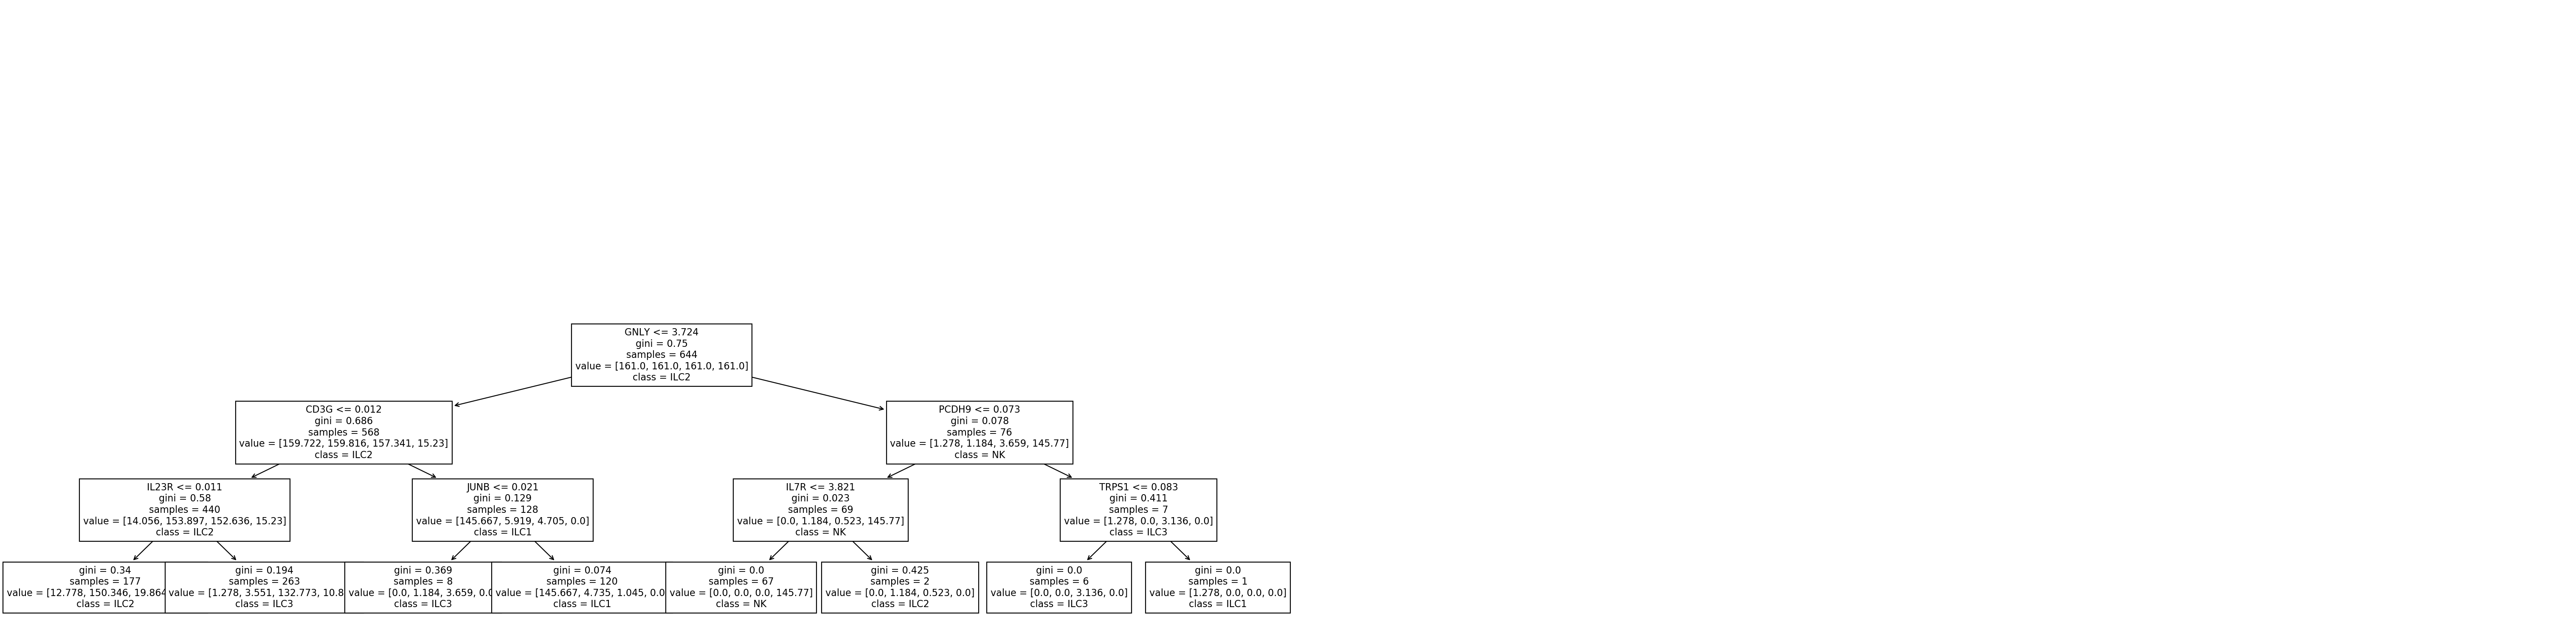

In [64]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")
classifier.fit(adata.raw.to_adata().X, adata.obs.type)
display(pd.DataFrame(confusion_matrix(y_true=adata.obs.type, 
                                      y_pred=classifier.predict(adata.raw.to_adata().X)
                                     ),
                     index=classifier.classes_, columns=classifier.classes_,
                     )
       )
fig, ax = plt.subplots(figsize=(48, 12))
tree.plot_tree(classifier, ax=ax, fontsize=10,
               feature_names=adata.raw.to_adata().var.symbol, class_names=classifier.classes_) 

... storing 'Tree3' as categorical


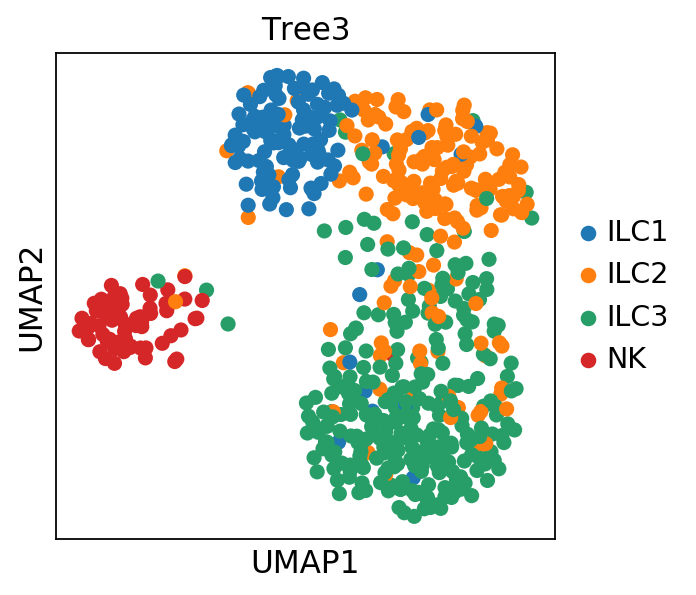

In [65]:
adata.obs['Tree3'] = classifier.predict(adata.raw.to_adata().X)
sc.pl.umap(adata, color='Tree3')

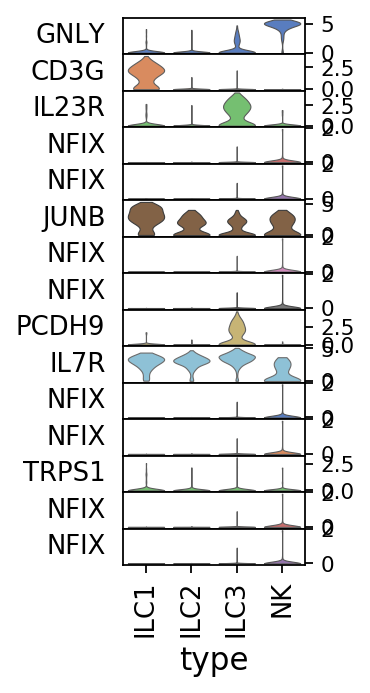

In [66]:
sc.pl.stacked_violin(adata, adata.raw.to_adata().var.symbol[classifier.tree_.feature].tolist(), 
                     groupby='type', rotation=90, swap_axes=True);

### Depth 4

ILC1  ILC2  ILC3  NK
ILC1   114     3     9   0
ILC2     1   128     7   0
ILC3     0    10   298   0
NK       0     1     3  70

[Text(1831.3043478260868, 875.52, 'GNLY <= 3.724\ngini = 0.75\nsamples = 644\nvalue = [161.0, 161.0, 161.0, 161.0]\nclass = ILC2'),
 Text(1085.2173913043478, 680.9599999999999, 'CD3G <= 0.012\ngini = 0.686\nsamples = 568\nvalue = [159.722, 159.816, 157.341, 15.23]\nclass = ILC2'),
 Text(542.6086956521739, 486.4, 'IL23R <= 0.011\ngini = 0.58\nsamples = 440\nvalue = [14.056, 153.897, 152.636, 15.23]\nclass = ILC2'),
 Text(271.30434782608694, 291.8399999999999, 'RN7SL2 <= 0.014\ngini = 0.34\nsamples = 177\nvalue = [12.778, 150.346, 19.864, 4.351]\nclass = ILC2'),
 Text(135.65217391304347, 97.27999999999997, 'gini = 0.649\nsamples = 43\nvalue = [10.222, 4.735, 15.682, 2.176]\nclass = ILC3'),
 Text(406.9565217391304, 97.27999999999997, 'gini = 0.111\nsamples = 134\nvalue = [2.556, 145.61, 4.182, 2.176]\nclass = ILC2'),
 Text(813.9130434782608, 291.8399999999999, 'KLRD1 <= 2.113\ngini = 0.194\nsamples = 263\nvalue = [1.278, 3.551, 132.773, 10.878]\nclass = ILC3'),
 Text(678.2608695652174, 97

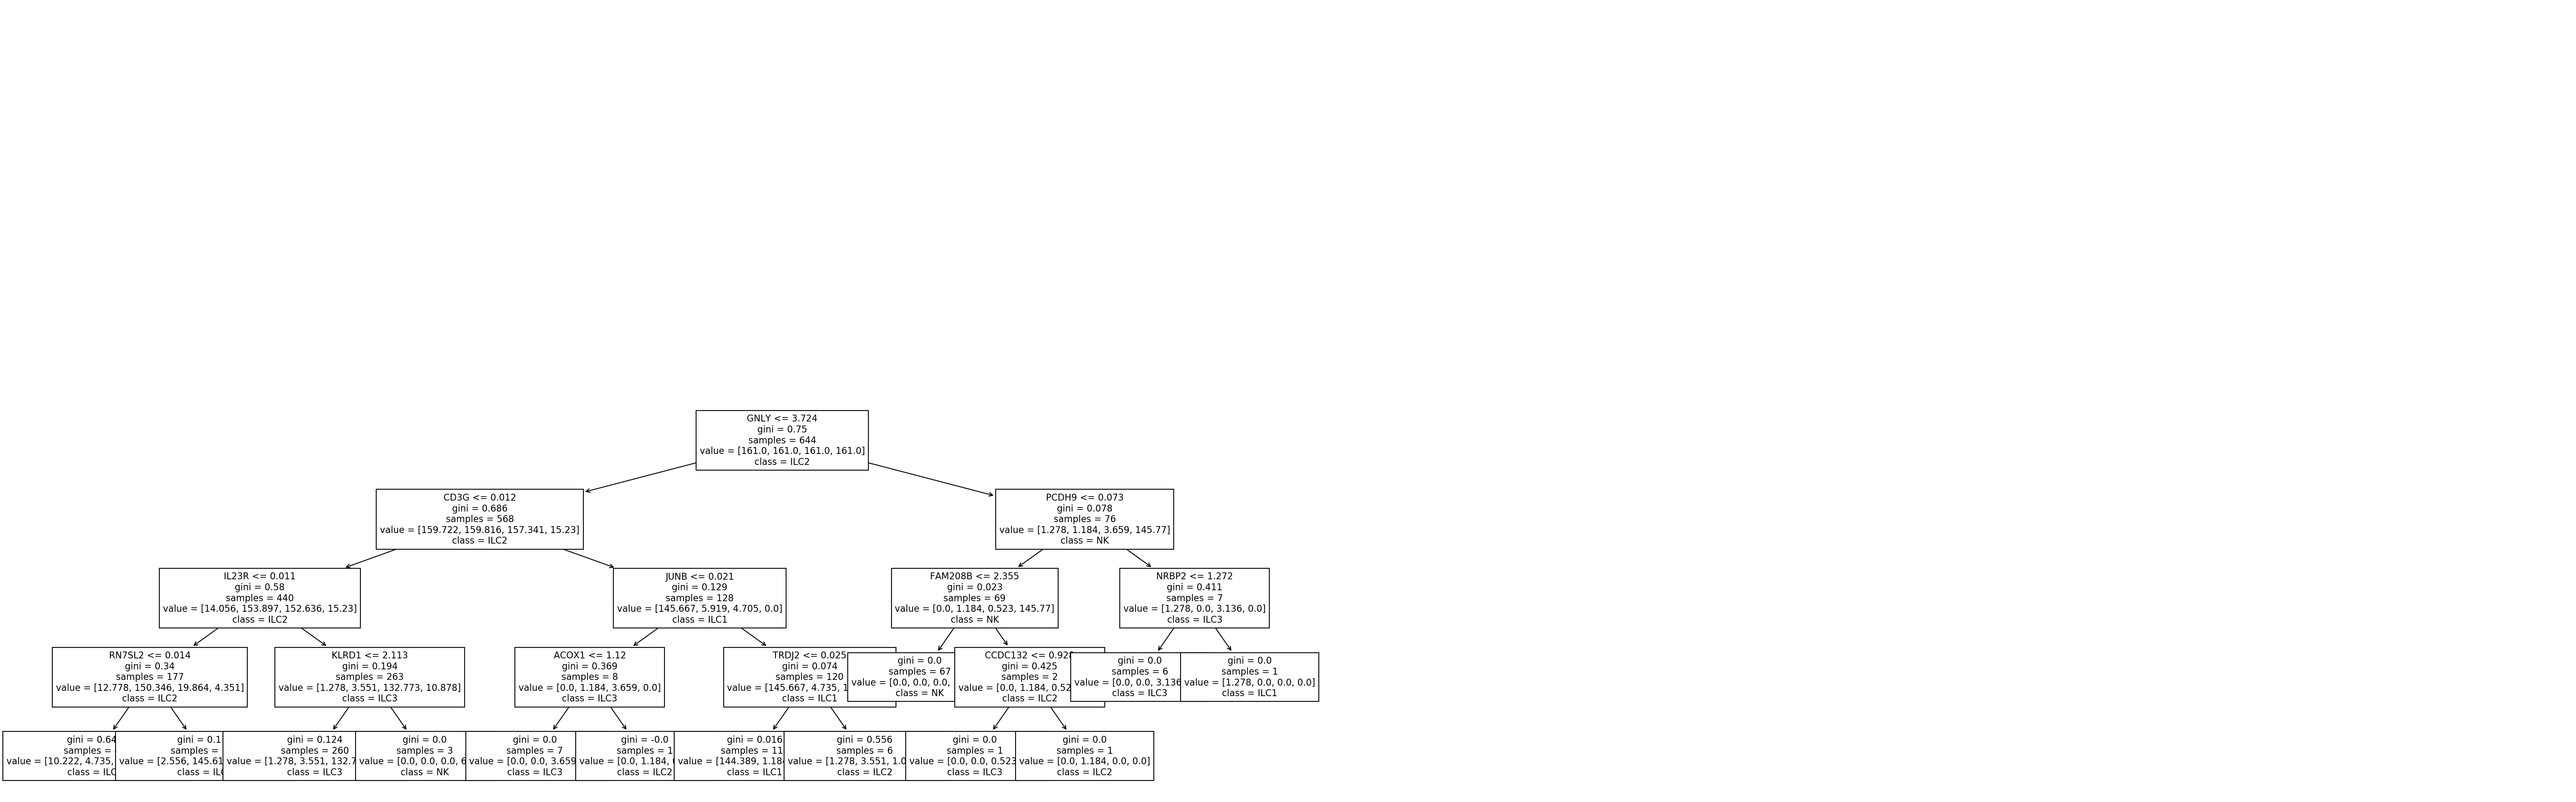

In [75]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=4, class_weight="balanced")
classifier.fit(adata.raw.to_adata().X, adata.obs.type)
display(pd.DataFrame(confusion_matrix(y_true=adata.obs.type, 
                                      y_pred=classifier.predict(adata.raw.to_adata().X)
                                     ),
                     index=classifier.classes_, columns=classifier.classes_)
       )
fig, ax = plt.subplots(figsize=(50, 16))
display(tree.plot_tree(classifier, ax=ax, fontsize=10,
                       feature_names=adata.raw.to_adata().var.symbol, class_names=classifier.classes_) 
       )

... storing 'Tree4' as categorical


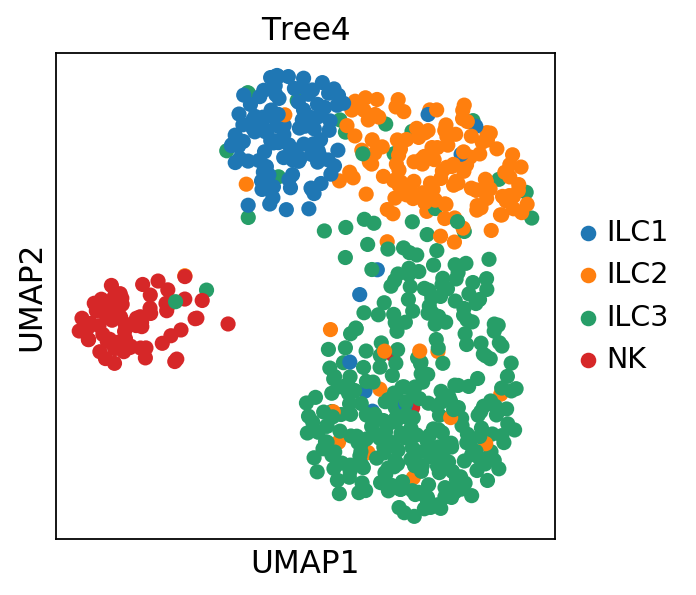

In [76]:
adata.obs['Tree4'] = classifier.predict(adata.raw.to_adata().X)
sc.pl.umap(adata, color='Tree4')

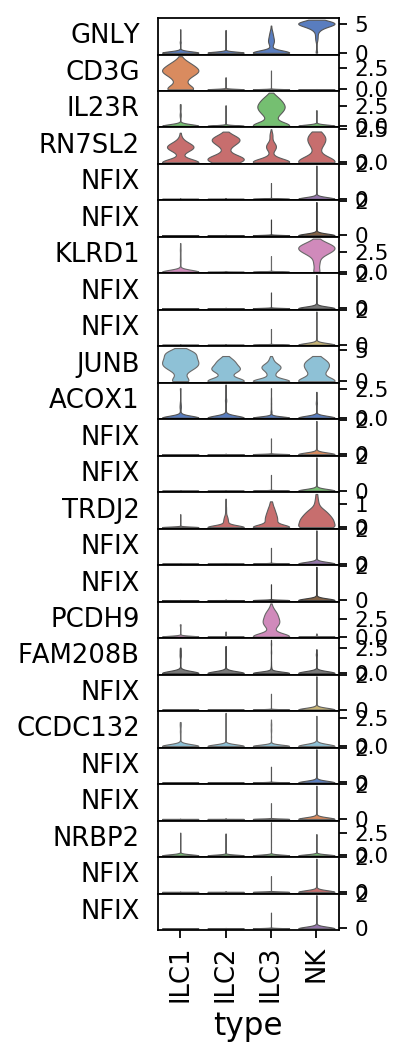

In [77]:
sc.pl.stacked_violin(adata.raw.to_adata(), adata.raw.to_adata().var.symbol[classifier.tree_.feature].tolist(), 
                     groupby='type', rotation=90, swap_axes=True);

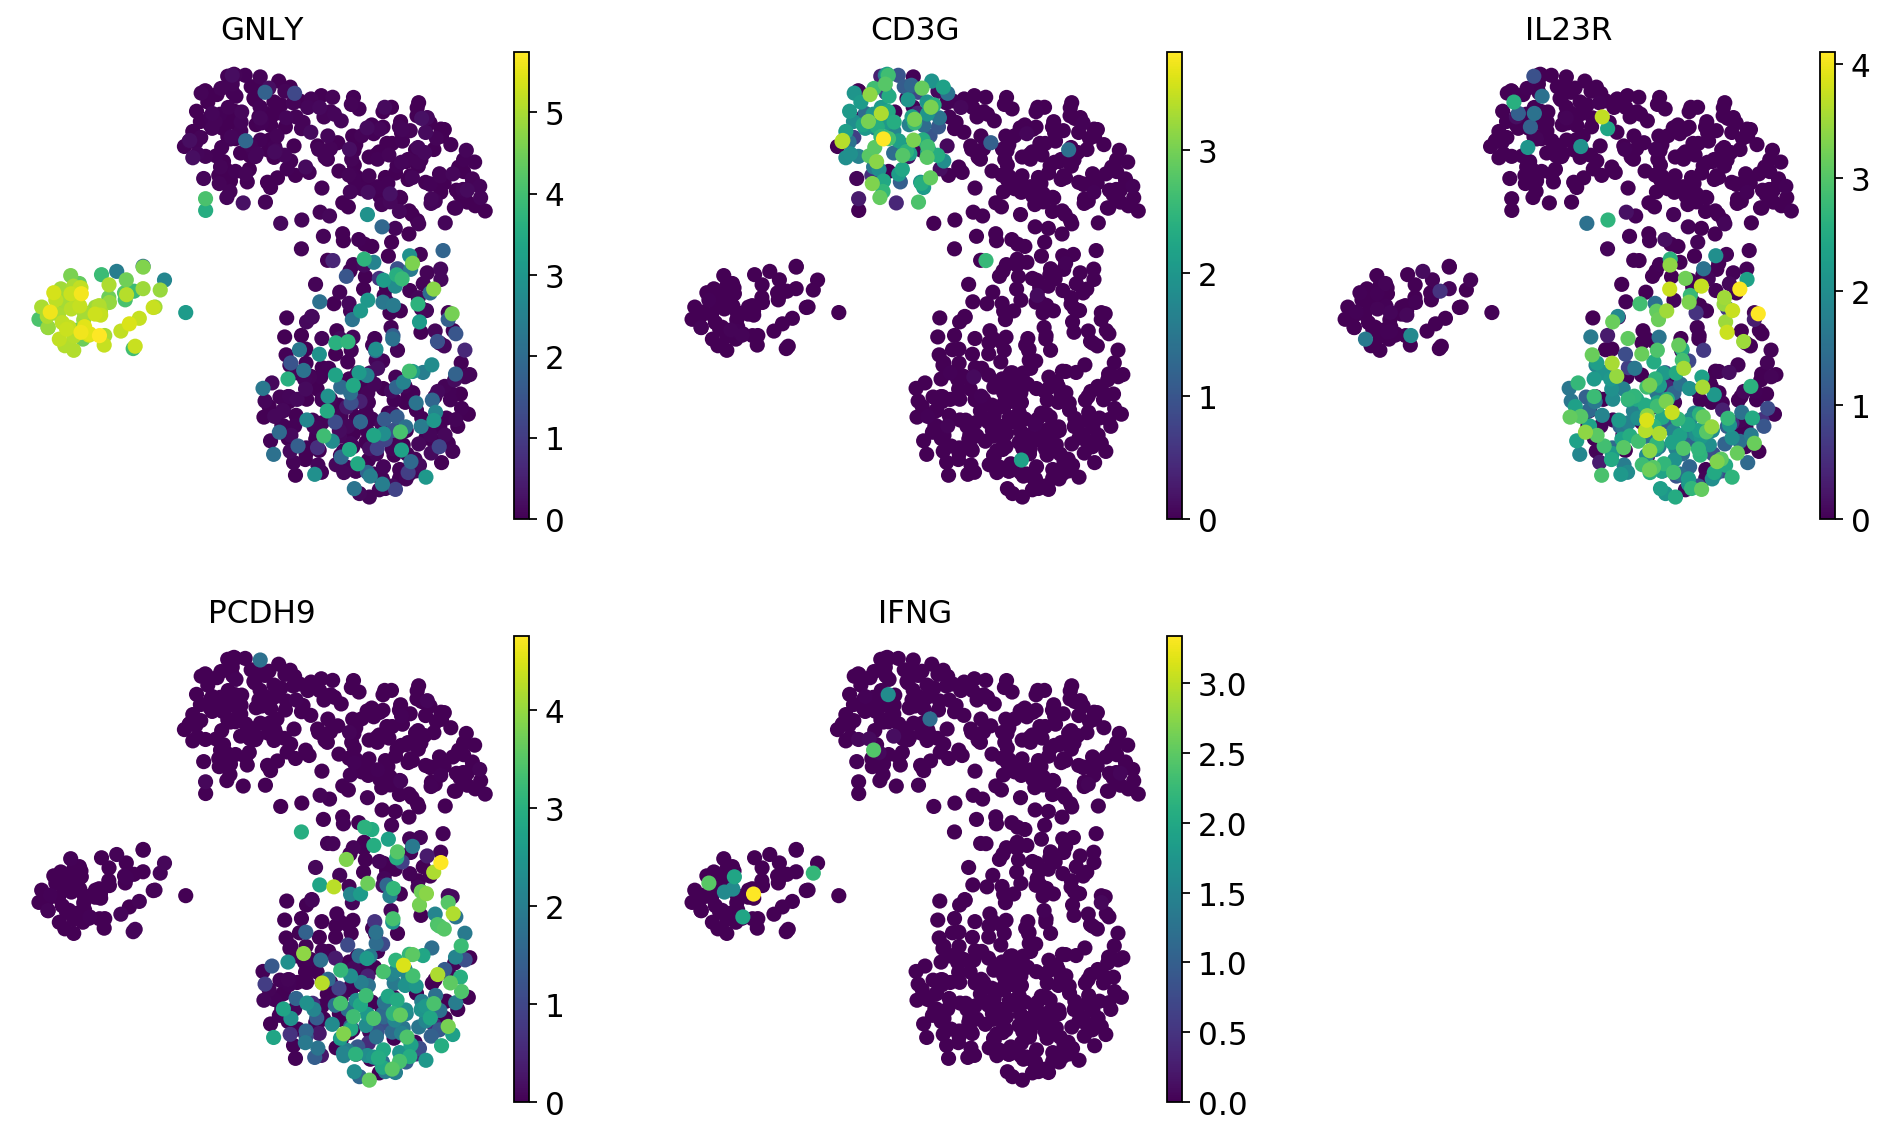

In [80]:
markers = ["GNLY", "CD3G", "IL23R", "PCDH9", "IFNG"]
sc.pl.umap(adata.raw.to_adata(), color=markers, frameon=False, ncols=3)